# Regresión Logística en Python

La regresión logística es uno de los métodos de aprendizaje automático que se utiliza para resolver problemas de clasificación binaria de una manera muy eficiente. Identifica una situación real (centro laboral, negocio, hogar) de la cual puedas adquirir una cantidad considerable de datos y que represente una problemática de clasificación binaria, por ejemplo: (0/1), (si/no), (continuar/detener), entre otras. Elabora un programa en Python donde, a partir del análisis previo del comportamiento de los datos, puedas elaborar un modelo capaz de predecir el resultado adecuado para nuevas condiciones que se pudieran presentar.

Vista previa de datos:
   tenure_meses  tarifa_mensual  horas_uso_semana  dispositivos_vinculados  \
0            19      119.778889         12.279110                        2   
1            11      166.091305          3.842739                        3   
2            11      116.334787          4.453980                        5   
3            11      195.601959          5.009483                        1   
4            37      171.885391          4.577774                        1   

   tickets_soporte_90d  autopago  recibio_promo     region  churn  
0                    1         1              1  Occidente      0  
1                    1         0              0      Norte      0  
2                    1         1              0     Centro      0  
3                    1         1              0     Centro      0  
4                    0         1              0        Sur      0  

Forma del dataset: (1000, 9)

Distribución de churn:
churn
0    969
1     31
Name: count, dtype: in

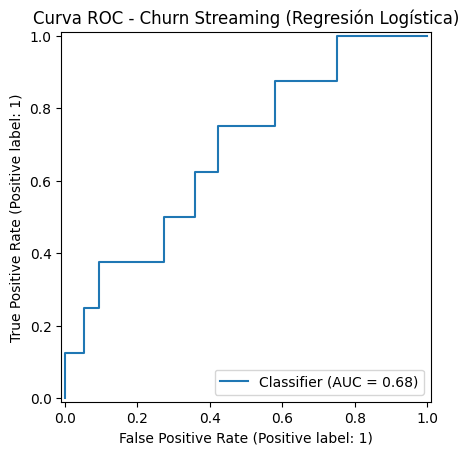


Coeficientes y Odds Ratios (interpretación local lineal):
                   feature  coeficiente  odds_ratio
4      tickets_soporte_90d     0.834239    2.303060
1           tarifa_mensual     0.303178    1.354156
3  dispositivos_vinculados     0.166370    1.181010
9               region_Sur     0.091818    1.096165
8         region_Occidente     0.044122    1.045110
2         horas_uso_semana    -0.317730    0.727800
0             tenure_meses    -0.594389    0.551900
6          recibio_promo_1    -0.647387    0.523412
7             region_Norte    -0.649571    0.522270
5               autopago_1    -1.034792    0.355300

=== Predicciones para nuevos clientes ===
Cliente 1: prob_churn=0.925  ->  Se dará de baja (1)
Cliente 2: prob_churn=0.059  ->  Seguirá activo (0)

Métricas con umbral=0.35 (priorizando recall):
Precision: 0.047
Recall:    0.750
F1-score:  0.088
Matriz de confusión:
 [[120 122]
 [  2   6]]


In [13]:
# ==============================================
# Predicción de churn en streaming con Regresión Logística
# ==============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt

# -----------------------------
# 1) Cargar dataset desde CSV
# -----------------------------
df = pd.read_csv("datos_churn.csv")
print("Vista previa de datos:")
print(df.head())
print(f"\nForma del dataset: {df.shape}")
print(f"\nDistribución de churn:")
print(df["churn"].value_counts())

# -----------------------------
# 2) Train/test split
# -----------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

num_cols = ["tenure_meses","tarifa_mensual","horas_uso_semana","dispositivos_vinculados","tickets_soporte_90d"]
cat_cols = ["autopago","recibio_promo","region"]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

# Modelo: Regresión Logística con balanceo por si las clases están desbalanceadas
log_reg = LogisticRegression(max_iter=200, class_weight="balanced", solver="lbfgs")

pipe = Pipeline(steps=[("pre", pre), ("clf", log_reg)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7, stratify=y
)

# -----------------------------
# 3) Entrenamiento y validación
# -----------------------------
pipe.fit(X_train, y_train)

# Validación cruzada rápida (AUC)
auc_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring="roc_auc").mean()
print(f"\nAUC (CV 5 folds) en train: {auc_cv:.3f}")

# -----------------------------
# 4) Evaluación en test
# -----------------------------
y_proba = pipe.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Métricas en test ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - Churn Streaming (Regresión Logística)")
plt.show()

# -----------------------------
# 5) Interpretabilidad: coeficientes y odds ratios
# -----------------------------
# Extraemos nombres de las columnas transformadas (num escaladas + dummies)
ohe = pipe.named_steps["pre"].named_transformers_["cat"]
feature_names_num = num_cols
feature_names_cat = ohe.get_feature_names_out(cat_cols).tolist()
feat_names = feature_names_num + feature_names_cat

coefs = pipe.named_steps["clf"].coef_.ravel()
odds = np.exp(coefs)
coef_table = pd.DataFrame({
    "feature": feat_names,
    "coeficiente": coefs,
    "odds_ratio": odds
}).sort_values(by="odds_ratio", ascending=False)

print("\nCoeficientes y Odds Ratios (interpretación local lineal):")
print(coef_table)

# -----------------------------
# 6) Predicción para nuevos clientes
# -----------------------------
nuevos_clientes = pd.DataFrame([
    {
        "tenure_meses": 2,
        "tarifa_mensual": 229,
        "horas_uso_semana": 3,
        "dispositivos_vinculados": 2,
        "tickets_soporte_90d": 2,
        "autopago": 0,
        "recibio_promo": 0,
        "region": "Sur"
    },
    {
        "tenure_meses": 18,
        "tarifa_mensual": 149,
        "horas_uso_semana": 14,
        "dispositivos_vinculados": 4,
        "tickets_soporte_90d": 0,
        "autopago": 1,
        "recibio_promo": 1,
        "region": "Occidente"
    }
])

prob_churn = pipe.predict_proba(nuevos_clientes)[:,1]
pred_churn = (prob_churn >= 0.5).astype(int)

print("\n=== Predicciones para nuevos clientes ===")
for i, (p, c) in enumerate(zip(prob_churn, pred_churn), start=1):
    print(f"Cliente {i}: prob_churn={p:.3f}  ->  {'Se dará de baja (1)' if c==1 else 'Seguirá activo (0)'}")

# -----------------------------
# 7) (Opcional) Ajustar umbral por objetivo de negocio
#    Ejemplo: priorizar recall (detectar más churns) con umbral 0.35
# -----------------------------
umbral = 0.35
y_pred_recall = (y_proba >= umbral).astype(int)
print(f"\nMétricas con umbral={umbral} (priorizando recall):")
print(f"Precision: {precision_score(y_test, y_pred_recall):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_recall):.3f}")
print(f"F1-score:  {f1_score(y_test, y_pred_recall):.3f}")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_recall))